# Feature Extraction Methods for Classification of Song Syllables

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import itertools
from pydub.utils import db_to_float
from scipy.signal import find_peaks
from scipy.signal import spectrogram
import antropy as ent
import numpy as np
import os
import csv
import pandas as pd
import os
import scipy.io
from PIL import Image
import csv
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
%load_ext autoreload
%autoreload 2
import final_ml as processor
from IPython.display import Image


2024-07-11 22:22:57.805806: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing in Matlab:
- .rhd audio files are analyzed and segmented using evsonganaly's threshold parameters 
- onsets and offsets for each syllable are saved into a .notmat file for a given song
- .rhd song files are then converted into a directory of .wav song files

## Processing in Python:
- .wav files are segmented using .notmat's saved onsets and offsets from evsonganaly segmentation
- result is a directory of a bunch of individual syllables in .wav format segmented based on onsets and offsets returned from evsonganaly's threshold parameters 
- a list of labeled syllables is also returned [[bird_song_syllable0, label0], [bird_song_syllable1, label1], [bird_song_syllable2, label2], ...]

In [21]:
#mat_folder = '/Users/felipe/Documents/Sober/Testers/mat_folder' #the folder containing the .notmat files
#mat_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-test-notmat' #the folder containing the .notmat files
mat_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-normal-notmat' #the folder containing the .notmat files
#wav_folder = '/Users/felipe/Documents/Sober/Testers/wav_folder' #the folder containing the song .wav files
#wav_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-test-wav' #the folder containing the song .wav files
wav_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-normal-wav' #the folder containing the song .wav files
#saveWav_folder = '/Users/felipe/Documents/Sober/Testers/saveWav_folder' #the folder to save your syllables and labeled CSV to
#saveWav_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-test-save_wav' #the folder to save your syllables and labeled CSV to
saveWav_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-normal-save_wav' #the folder to save your syllables and labeled CSV to

labeled_CSV_path, syllable_label = processor.split_matlab(mat_folder, wav_folder, saveWav_folder)

#returns the path of the CSV file and a sorted list of [(syllable_name,label)...]


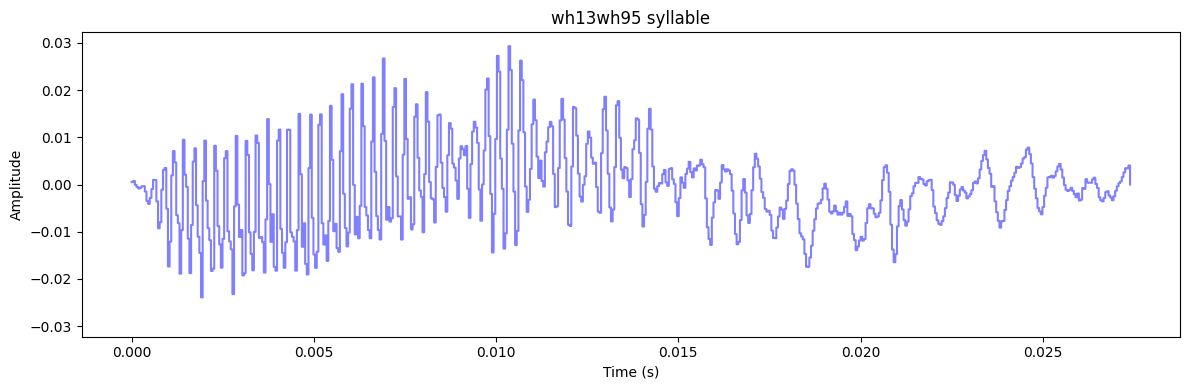

In [4]:
# Sanity check 1 - visualize a syllable in its raw waveform

syl_path = '/Users/felipe/Documents/Sober/Testers/saveWav_folder/wh13wh95_010224_0638.1920_syllable6.wav' #the path of a syllable you want to visualize

processor.view_segment(syl_path)


## Feature Extraction
we take two approaches for syllable feature extraction
1. Acoustic features -  wiener entropy, spectral entropy, gravity center, spectral width, f0, max frequency, mfccs, and duration

2. Visual features - an array of abstract feature maps representing the syallable's power spectrogram image

we will save the syllable features in seperate labeled CSV files (1 for acoustic features, and 1 for visual features)



### Acoustic Feature Extraction:


important internal parameters defined:
- y = raw time vs amplitude array of syllable
- sr = sample rate (30,000Hz)
- N = number of samples in raw audio array
  - N = len(y)
  - is used as the fft size (n_fft = N)
- ft = frequency vs amplitude array
  - ft = np.fft.fft(y, n = N) #frequency vs complex_numbers array 
  - ft = np.abs(ft) #abs(complex_numbers) converts to magnitude/amplitude
- duration = samples / sampling rate
  - duration = N / sr

computing frequency bins for FT size:
- freq_bins = np.fft.fftfreq(N, 1/sr)
  -  creates frequency bin array with of df intervals (df = sr / N)
  -   EX: if sr = 30,000 and syl = 2 seconds long (60,000 samples), then df = 1/2 meaning that frequency bins = [0,0.5hz,1hz,1.5hz,2hz,...,f_max,-f_max,...,-1.5 Hz,-1Hz,-0.5 Hz]

select only the positve frequency bins and corresponding ft amplitudes:
- positive_freq_bins = first half of frequency bins
  - freq_bins[:N // 2]
- positive_ft = first half of ft values
  - positive_ft[:N // 2]

In [25]:
#acoustic_features_CSV_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-test-acoustic_features_CSV_folder' #where you want to save your CSV file to
acoustic_features_CSV_folder = '/Users/felipe/Documents/Sober/Testers/Jul-8-normal-acoustic_features_CSV_folder' #where you want to save your CSV file to
#saveSpec_folder = '/Users/felipe/Documents/Sober/Testers/saveSpec_folder' #path where to save power spectrogram images. leave blank if you do not want to save them
saveSpec_folder = ''
#note: spectrograms are power spectrograms in dB scale

y, sr, selected_freq, selected_ft, f0, acoustic_features_CSV_path =  processor.extract_from_waveform(saveWav_folder, acoustic_features_CSV_folder, syllable_label, saveSpec_folder, mid = False)


wh13wh95_020224_0703.4435_syllable2 has 0 samples. File is likely broken and needs manual removal from directory


Frequency bins size 101
Ft size 101


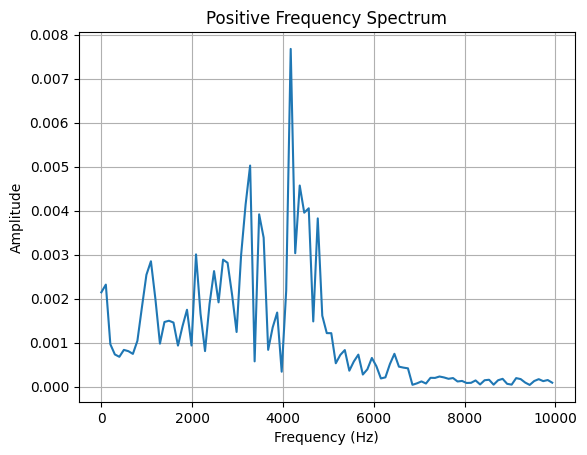

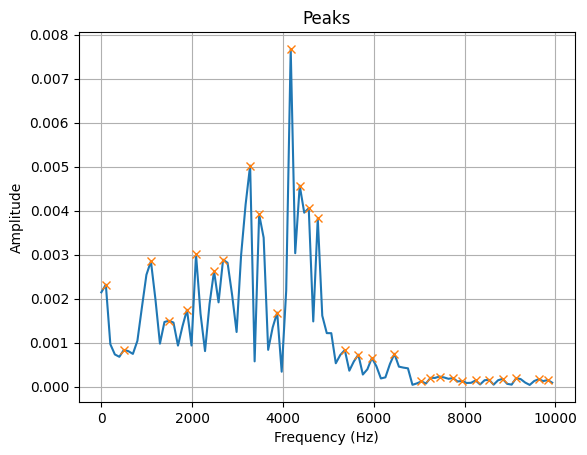

In [19]:
#Sanity check 2 - each df in frequency bin array has a corresponding amplitude

# visualization of frequency range 0-10,000Hz and corresponding ft values
print("Frequency bins size {}".format(np.size(selected_freq)))
print("Ft size {}".format(np.size(selected_ft)))

# plot ft
plt.figure()
plt.plot(selected_freq, selected_ft)
plt.title("Positive Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# plot all frequency peaks
peaks, _ = find_peaks(selected_ft, height=0)
plt.title("Peaks")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.plot(selected_freq, selected_ft)
plt.plot(selected_freq[peaks], selected_ft[peaks], "x")
plt.grid()
plt.show()




Lets talk about N, n_fft, frequency resolution, and temporal resolution...

1. N = number of samples
2. n_fft = the N you want to use to for the fft
3. Frequency resolution = how good you can differentiate between frequency components
4. Temporal resolution = how good your timing is

delta_frequency (df) = sample_rate / samples... aka sr / n_fft
- df = frequency resolution = the frequency band (width) of a bin
  - ex. if sr = 30,000 and syl = 2 seconds long (60,000 samples), then df = 1/2 meaning that... frequency bins = [0,.5hz,1hz,1.5hz,2hz,etc]
- the wider, the worse the resolution
- having more samples (N) improves our FREQUENCY resolution but worsens your TEMPORAL resolution

Defining FFT size:
- when doing fft, many set N samples = n_fft = the next biggest power of 2
  - i.e., if N = 1800, n_fft = 2048
  - this uses zero-padding
- this is for a few reasons:
  - frequencies are more distinguishable when n_fft is higher
  - computational efficiency (fft doesn't like prime numbers)
Right now, let's not pad the syllable since we want to keep a good temporal resolution and frequency resolution should be high enough as is
- n_fft = N

(but if we were too...)
- N_fft = 1024
- ft = np.fft.fft(y, n = N_fft)
- df = sr / N_fft
- freq_bins = np.fft.fftfreq(N_fft, 1/sr)

Fundamental Frequency Problem:
- librosa.pyin cannot find f0 for some syllables (most are NaN)
- I use fmin = 10 and fmax = 6000

Lets visualize it though

In [ ]:
processor.plot_f0(sr, selected_ft, f0)


#### Lets visualize the distribution of each feature/variable and the outliers in our dataset

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

# Load the CSV file into a DataFrame
a = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_a.csv')
b = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_b.csv')
c = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_c.csv')
d = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_d.csv')
D = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_Dbig.csv')
e = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_e.csv')
f = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_f.csv')
g = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_g.csv')
h = pd.read_csv('/Users/felipe/Documents/Sober/Testers/distributions/syl_h.csv')

# Normalize the data using Z-score normalization
scaler = StandardScaler()

# Extract the column you want to normalize
a_we = a['Wiener Entropy']
a_se = a['Spectral Entropy']
a_gc = a['Gravity Center']
a_sw = a['Spectral Width']
a_mf = a['Max Frequency']
a_cc = a['MFCCs']
a_du = a['Duration']

# normalize to z-score (mean = 0, std = 1)
normalized_a_we = scaler.fit_transform(a_we.values.reshape(-1, 1))
normalized_a_se = scaler.fit_transform(a_se.values.reshape(-1, 1))
normalized_a_gc = scaler.fit_transform(a_gc.values.reshape(-1, 1))
normalized_a_sw = scaler.fit_transform(a_sw.values.reshape(-1, 1))
normalized_a_mf = scaler.fit_transform(a_mf.values.reshape(-1, 1))
normalized_a_cc = scaler.fit_transform(a_cc.values.reshape(-1, 1))
normalized_a_du = scaler.fit_transform(a_du.values.reshape(-1, 1))

a_fet = []
a_fet.append(a_we)
a_fet.append(a_se)
a_fet.append(a_gc) 
a_fet.append(a_sw)
a_fet.append(a_mf)
a_fet.append(a_cc)
a_fet.append(a_du)


a_fet_norm = []
a_fet_norm.append(normalized_a_we)
a_fet_norm.append(normalized_a_se)
a_fet_norm.append(normalized_a_gc)
a_fet_norm.append(normalized_a_sw)
a_fet_norm.append(normalized_a_mf)
a_fet_norm.append(normalized_a_cc)
a_fet_norm.append(normalized_a_du)


#######################################################################################################################################
b_we = b['Wiener Entropy']
b_se = b['Spectral Entropy']
b_gc = b['Gravity Center']
b_sw = b['Spectral Width']
b_mf = b['Max Frequency']
b_cc = b['MFCCs']
b_du = b['Duration']

normalized_b_we = scaler.fit_transform(b_we.values.reshape(-1, 1))
normalized_b_se = scaler.fit_transform(b_se.values.reshape(-1, 1))
normalized_b_gc = scaler.fit_transform(b_gc.values.reshape(-1, 1))
normalized_b_sw = scaler.fit_transform(b_sw.values.reshape(-1, 1))
normalized_b_mf = scaler.fit_transform(b_mf.values.reshape(-1, 1))
normalized_b_cc = scaler.fit_transform(b_cc.values.reshape(-1, 1))
normalized_b_du = scaler.fit_transform(b_du.values.reshape(-1, 1))

b_fet = []
b_fet.append(b_we)
b_fet.append(b_se)
b_fet.append(b_gc) 
b_fet.append(b_sw)
b_fet.append(b_mf)
b_fet.append(b_cc)
b_fet.append(b_du)


b_fet_norm = []
b_fet_norm.append(normalized_b_we)
b_fet_norm.append(normalized_b_se)
b_fet_norm.append(normalized_b_gc)
b_fet_norm.append(normalized_b_sw)
b_fet_norm.append(normalized_b_mf)
b_fet_norm.append(normalized_b_cc)
b_fet_norm.append(normalized_b_du)


#######################################################################################################################################

c_we = c['Wiener Entropy']
c_se = c['Spectral Entropy']
c_gc = c['Gravity Center']
c_sw = c['Spectral Width']
c_mf = c['Max Frequency']
c_cc = c['MFCCs']
c_du = c['Duration']

normalized_c_we = scaler.fit_transform(c_we.values.reshape(-1, 1))
normalized_c_se = scaler.fit_transform(c_se.values.reshape(-1, 1))
normalized_c_gc = scaler.fit_transform(c_gc.values.reshape(-1, 1))
normalized_c_sw = scaler.fit_transform(c_sw.values.reshape(-1, 1))
normalized_c_mf = scaler.fit_transform(c_mf.values.reshape(-1, 1))
normalized_c_cc = scaler.fit_transform(c_cc.values.reshape(-1, 1))
normalized_c_du = scaler.fit_transform(c_du.values.reshape(-1, 1))

c_fet = []
c_fet.append(c_we)
c_fet.append(c_se)
c_fet.append(c_gc) 
c_fet.append(c_sw)
c_fet.append(c_mf)
c_fet.append(c_cc)
c_fet.append(c_du)


c_fet_norm = []
c_fet_norm.append(normalized_c_we)
c_fet_norm.append(normalized_c_se)
c_fet_norm.append(normalized_c_gc)
c_fet_norm.append(normalized_c_sw)
c_fet_norm.append(normalized_c_mf)
c_fet_norm.append(normalized_c_cc)
c_fet_norm.append(normalized_c_du)

#######################################################################################################################################

d_we = d['Wiener Entropy']
d_se = d['Spectral Entropy']
d_gc = d['Gravity Center']
d_sw = d['Spectral Width']
d_mf = d['Max Frequency']
d_cc = d['MFCCs']
d_du = d['Duration']

normalized_d_we = scaler.fit_transform(d_we.values.reshape(-1, 1))
normalized_d_se = scaler.fit_transform(d_se.values.reshape(-1, 1))
normalized_d_gc = scaler.fit_transform(d_gc.values.reshape(-1, 1))
normalized_d_sw = scaler.fit_transform(d_sw.values.reshape(-1, 1))
normalized_d_mf = scaler.fit_transform(d_mf.values.reshape(-1, 1))
normalized_d_cc = scaler.fit_transform(d_cc.values.reshape(-1, 1))
normalized_d_du = scaler.fit_transform(d_du.values.reshape(-1, 1))

d_fet = []
d_fet.append(d_we)
d_fet.append(d_se)
d_fet.append(d_gc) 
d_fet.append(d_sw)
d_fet.append(d_mf)
d_fet.append(d_cc)
d_fet.append(d_du)


d_fet_norm = []
d_fet_norm.append(normalized_d_we)
d_fet_norm.append(normalized_d_se)
d_fet_norm.append(normalized_d_gc)
d_fet_norm.append(normalized_d_sw)
d_fet_norm.append(normalized_d_mf)
d_fet_norm.append(normalized_d_cc)
d_fet_norm.append(normalized_d_du)


#######################################################################################################################################

D_we = D['Wiener Entropy']
D_se = D['Spectral Entropy']
D_gc = D['Gravity Center']
D_sw = D['Spectral Width']
D_mf = D['Max Frequency']
D_cc = D['MFCCs']
D_du = D['Duration']

normalized_D_we = scaler.fit_transform(D_we.values.reshape(-1, 1))
normalized_D_se = scaler.fit_transform(D_se.values.reshape(-1, 1))
normalized_D_gc = scaler.fit_transform(D_gc.values.reshape(-1, 1))
normalized_D_sw = scaler.fit_transform(D_sw.values.reshape(-1, 1))
normalized_D_mf = scaler.fit_transform(D_mf.values.reshape(-1, 1))
normalized_D_cc = scaler.fit_transform(D_cc.values.reshape(-1, 1))
normalized_D_du = scaler.fit_transform(D_du.values.reshape(-1, 1))

D_fet = []
D_fet.append(D_we)
D_fet.append(D_se)
D_fet.append(D_gc) 
D_fet.append(D_sw)
D_fet.append(D_mf)
D_fet.append(D_cc)
D_fet.append(D_du)


D_fet_norm = []
D_fet_norm.append(normalized_D_we)
D_fet_norm.append(normalized_D_se)
D_fet_norm.append(normalized_D_gc)
D_fet_norm.append(normalized_D_sw)
D_fet_norm.append(normalized_D_mf)
D_fet_norm.append(normalized_D_cc)
D_fet_norm.append(normalized_D_du)

#######################################################################################################################################

e_we = e['Wiener Entropy']
e_se = e['Spectral Entropy']
e_gc = e['Gravity Center']
e_sw = e['Spectral Width']
e_mf = e['Max Frequency']
e_cc = e['MFCCs']
e_du = e['Duration']

normalized_e_we = scaler.fit_transform(e_we.values.reshape(-1, 1))
normalized_e_se = scaler.fit_transform(e_se.values.reshape(-1, 1))
normalized_e_gc = scaler.fit_transform(e_gc.values.reshape(-1, 1))
normalized_e_sw = scaler.fit_transform(e_sw.values.reshape(-1, 1))
normalized_e_mf = scaler.fit_transform(e_mf.values.reshape(-1, 1))
normalized_e_cc = scaler.fit_transform(e_cc.values.reshape(-1, 1))
normalized_e_du = scaler.fit_transform(e_du.values.reshape(-1, 1))

e_fet = []
e_fet.append(e_we)
e_fet.append(e_se)
e_fet.append(e_gc) 
e_fet.append(e_sw)
e_fet.append(e_mf)
e_fet.append(e_cc)
e_fet.append(e_du)


e_fet_norm = []
e_fet_norm.append(normalized_e_we)
e_fet_norm.append(normalized_e_se)
e_fet_norm.append(normalized_e_gc)
e_fet_norm.append(normalized_e_sw)
e_fet_norm.append(normalized_e_mf)
e_fet_norm.append(normalized_e_cc)
e_fet_norm.append(normalized_e_du)

#######################################################################################################################################

f_we = f['Wiener Entropy']
f_se = f['Spectral Entropy']
f_gc = f['Gravity Center']
f_sw = f['Spectral Width']
f_mf = f['Max Frequency']
f_cc = f['MFCCs']
f_du = f['Duration']

normalized_f_we = scaler.fit_transform(f_we.values.reshape(-1, 1))
normalized_f_se = scaler.fit_transform(f_se.values.reshape(-1, 1))
normalized_f_gc = scaler.fit_transform(f_gc.values.reshape(-1, 1))
normalized_f_sw = scaler.fit_transform(f_sw.values.reshape(-1, 1))
normalized_f_mf = scaler.fit_transform(f_mf.values.reshape(-1, 1))
normalized_f_cc = scaler.fit_transform(f_cc.values.reshape(-1, 1))
normalized_f_du = scaler.fit_transform(f_du.values.reshape(-1, 1))

f_fet = []
f_fet.append(f_we)
f_fet.append(f_se)
f_fet.append(f_gc) 
f_fet.append(f_sw)
f_fet.append(f_mf)
f_fet.append(f_cc)
f_fet.append(f_du)

f_fet_norm = []
f_fet_norm.append(normalized_f_we)
f_fet_norm.append(normalized_f_se)
f_fet_norm.append(normalized_f_gc)
f_fet_norm.append(normalized_f_sw)
f_fet_norm.append(normalized_f_mf)
f_fet_norm.append(normalized_f_cc)
f_fet_norm.append(normalized_f_du)


#######################################################################################################################################

g_we = g['Wiener Entropy']
g_se = g['Spectral Entropy']
g_gc = g['Gravity Center']
g_sw = g['Spectral Width']
g_mf = g['Max Frequency']
g_cc = g['MFCCs']
g_du = g['Duration']

normalized_g_we = scaler.fit_transform(g_we.values.reshape(-1, 1))
normalized_g_se = scaler.fit_transform(g_se.values.reshape(-1, 1))
normalized_g_gc = scaler.fit_transform(g_gc.values.reshape(-1, 1))
normalized_g_sw = scaler.fit_transform(g_sw.values.reshape(-1, 1))
normalized_g_mf = scaler.fit_transform(g_mf.values.reshape(-1, 1))
normalized_g_cc = scaler.fit_transform(g_cc.values.reshape(-1, 1))
normalized_g_du = scaler.fit_transform(g_du.values.reshape(-1, 1))

g_fet = []
g_fet.append(g_we)
g_fet.append(g_se)
g_fet.append(g_gc) 
g_fet.append(g_sw)
g_fet.append(g_mf)
g_fet.append(g_cc)
g_fet.append(g_du)


g_fet_norm = []
g_fet_norm.append(normalized_g_we)
g_fet_norm.append(normalized_g_se)
g_fet_norm.append(normalized_g_gc)
g_fet_norm.append(normalized_g_sw)
g_fet_norm.append(normalized_g_mf)
g_fet_norm.append(normalized_g_cc)
g_fet_norm.append(normalized_g_du)


#######################################################################################################################################

h_we = h['Wiener Entropy']
h_se = h['Spectral Entropy']
h_gc = h['Gravity Center']
h_sw = h['Spectral Width']
h_mf = h['Max Frequency']
h_cc = h['MFCCs']
h_du = h['Duration']

normalized_h_we = scaler.fit_transform(h_we.values.reshape(-1, 1))
normalized_h_se = scaler.fit_transform(h_se.values.reshape(-1, 1))
normalized_h_gc = scaler.fit_transform(h_gc.values.reshape(-1, 1))
normalized_h_sw = scaler.fit_transform(h_sw.values.reshape(-1, 1))
normalized_h_mf = scaler.fit_transform(h_mf.values.reshape(-1, 1))
normalized_h_cc = scaler.fit_transform(h_cc.values.reshape(-1, 1))
normalized_h_du = scaler.fit_transform(h_du.values.reshape(-1, 1))

h_fet = []
h_fet.append(h_we)
h_fet.append(h_se)
h_fet.append(h_gc) 
h_fet.append(h_sw)
h_fet.append(h_mf)
h_fet.append(h_cc)
h_fet.append(h_du)


h_fet_norm = []
h_fet_norm.append(normalized_h_we)
h_fet_norm.append(normalized_h_se)
h_fet_norm.append(normalized_h_gc)
h_fet_norm.append(normalized_h_sw)
h_fet_norm.append(normalized_h_mf)
h_fet_norm.append(normalized_h_cc)
h_fet_norm.append(normalized_h_du)



In [ ]:
fet_names = ["Wiener Entropy", "Spectral Entropy", "Gravity Center", "Spectral Width", "Max Frequency", "MFCCs", "Duration"]

# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=a_fet[i], fill=False)
    sns.stripplot(data=a_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable a - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(a_fet_norm[i], kde=True)
    plt.title('Syllable a - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = a[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable a stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=b_fet[i], fill=False)
    sns.stripplot(data=b_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable b - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(b_fet_norm[i], kde=True)
    plt.title('Syllable b - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = b[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable b stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=c_fet[i], fill=False)
    sns.stripplot(data=c_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable c - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(c_fet_norm[i], kde=True)
    plt.title('Syllable c - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = c[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable c stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=d_fet[i], fill=False)
    sns.stripplot(data=d_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable d - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(d_fet_norm[i], kde=True)
    plt.title('Syllable d - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = d[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable d stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=D_fet[i], fill=False)
    sns.stripplot(data=D_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable D - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(D_fet_norm[i], kde=True)
    plt.title('Syllable D - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = D[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable D stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=e_fet[i], fill=False)
    sns.stripplot(data=e_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable e - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(e_fet_norm[i], kde=True)
    plt.title('Syllable e - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = e[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable e stats:")
print(stats)

# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=f_fet[i], fill=False)
    sns.stripplot(data=f_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable f - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(f_fet_norm[i], kde=True)
    plt.title('Syllable f - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = f[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable f stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=g_fet[i], fill=False)
    sns.stripplot(data=g_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable g - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(g_fet_norm[i], kde=True)
    plt.title('Syllable g - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = g[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable g stats:")
print(stats)


# Plotting the violin plot with strip plot
plt.figure(figsize=(12, 36))

for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.violinplot(data=h_fet[i], fill=False)
    sns.stripplot(data=h_fet[i], color="royalblue", jitter=True, size=3)
    plt.title('Syllable h - {}'.format(fet_names[i]))
plt.show()

# Plot normalized data distribution
plt.figure(figsize=(12, 36))
for i in range (7):
    plt.subplot(7, 1, i+1)
    sns.histplot(h_fet_norm[i], kde=True)
    plt.title('Syllable h - {}'.format(fet_names[i]))
plt.tight_layout()
plt.show()

stats = h[['Wiener Entropy','Spectral Width','Spectral Entropy','MFCCs','Max Frequency','Gravity Center','Duration']].describe()
print("syllable h stats:")
print(stats)


In [ ]:
syl_names = ["syllable a", "syllable b", "syllable c", "syllable d", "syllable D", "syllable e", "syllable f", "syllable g", "syllable h"]

normalized_all = []
normalized_all.append(a_fet_norm)
normalized_all.append(b_fet_norm)
normalized_all.append(c_fet_norm)
normalized_all.append(d_fet_norm)
normalized_all.append(D_fet_norm)
normalized_all.append(e_fet_norm)
normalized_all.append(f_fet_norm)
normalized_all.append(g_fet_norm)
normalized_all.append(h_fet_norm)

palette = sns.color_palette("deep", 9)

for i in range (7):
    plt.figure(figsize=(14, 8))
    for j in range(9):
        sns.kdeplot(normalized_all[j][i].squeeze(), label=syl_names[j], color = palette[j])
    plt.title('{} Distributions'.format(fet_names[i]))
    plt.xlabel('Normalized {}'.format(fet_names[i]))
    plt.ylabel('Density')
    plt.legend(title='Syllables')
    plt.show()


In [41]:
a_we = a['Wiener Entropy']
a_se = a['Spectral Entropy']
a_gc = a['Gravity Center']
a_sw = a['Spectral Width']
a_mf = a['Max Frequency']
a_cc = a['MFCCs']
a_du = a['Duration']

fet_all = []
fet_all.append(a_fet)
fet_all.append(b_fet)
fet_all.append(c_fet)
fet_all.append(d_fet)
fet_all.append(D_fet)
fet_all.append(e_fet)
fet_all.append(f_fet)
fet_all.append(g_fet)
fet_all.append(h_fet)

#9 syllables
#7 features

normality_row = []
std_row = []
header = fet_names
first_col = syl_names

for i in range(9):
	syl_normal_row = []
	syl_std_row = []
	for j in range(7):
		stat, p = shapiro(fet_all[i][j])
		if p > 0.05:
			syl_normal_row.append("normal")
		else:
			syl_normal_row.append("not normal")
		std = round(fet_all[i][j].std(),3)
		syl_std_row.append(std)
	normality_row.append(syl_normal_row)
	std_row.append(syl_std_row)

# Convert to DataFrames
df_normality = pd.DataFrame(normality_row, columns=header, index=first_col)
df_std = pd.DataFrame(std_row, columns=header, index=first_col)

# Save to CSV
df_normality.to_csv("./distributions/normality.csv", index=True)
df_std.to_csv("./distributions/std.csv", index=True)



In [42]:
for i, syl in enumerate(fet_all):
    # Convert the list of Series into a DataFrame
    df = pd.concat(syl, axis=1)
    
    # Compute the correlation matrix
    corr_matrix = df.corr()
    
    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f',
                annot_kws={'size': 10}, linewidths=0.5, linecolor='black')
    plt.title(f'Correlation Matrix for {syl_names[i]}')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # Save the plot as an image file
    plt.savefig(f"./distributions/correlation_matrix_syllable_{syl_names[i]}_{i}.png", bbox_inches='tight')
    plt.close()


### Visual Feature Extraction:
- uses a CNN to reduce spectrogram images into a flat 128 dimension array
- a few spectrograms come out as fully white (?) so we remove those and output a filtered labeled CSV without the syllables that created white images
- accepted images are preprocessed by zero-centering with respect to the ImageNet dataset without scaling before pushing to CNN


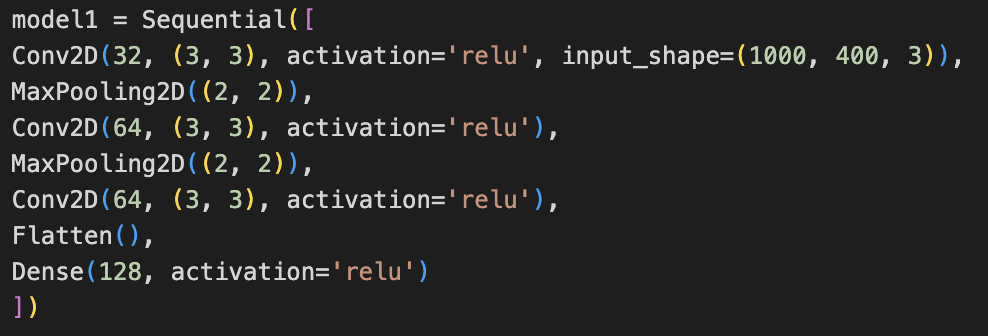

In [8]:
# CNN Architecture Used
Image('/Users/felipe/Desktop/Screenshot.png')


In [9]:
images_folder = saveSpec_folder #where we saved the spectrogram images

processor.remove_white_spec(images_folder)

labeled_filteredCSV_folder = '/Users/felipe/Documents/Sober/Testers/labeled_filteredCSV_folder' #folder where you want to store a filtered CSV without syllables (and their labeles) that output white images
labeled_filteredCSV_path = processor.filter_labels(labeled_CSV_path, labeled_filteredCSV_folder, images_folder)
#returns path of filtered CSV


Removing white image:  wh13wh95_010224_0638.1920_syllable5.png


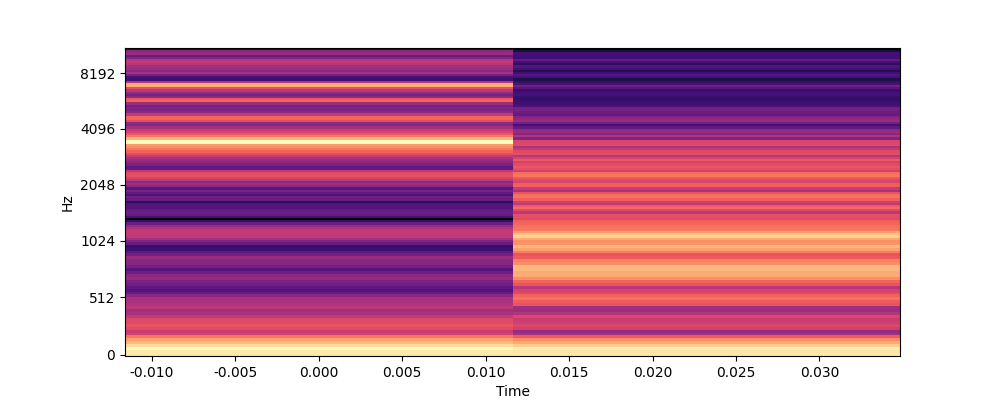

In [10]:
#Sanity check 3 - Lets visualize the power spectrogram (dB) for the same syllable as before

syl_path = '/Users/felipe/Documents/Sober/Testers/saveSpec_folder2/wh13wh95_010224_0638.1920_syllable6.png'

#saveSpec_folder2 has the plotted version with all the axis for easier analysis

Image(syl_path)


/opt/anaconda3/envs/soberlab/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


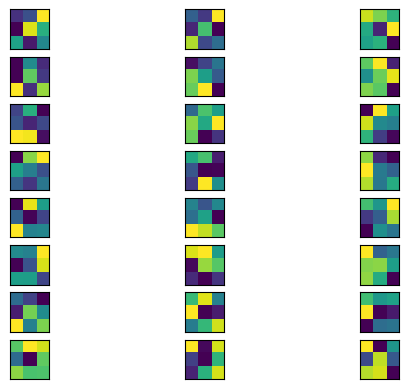

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


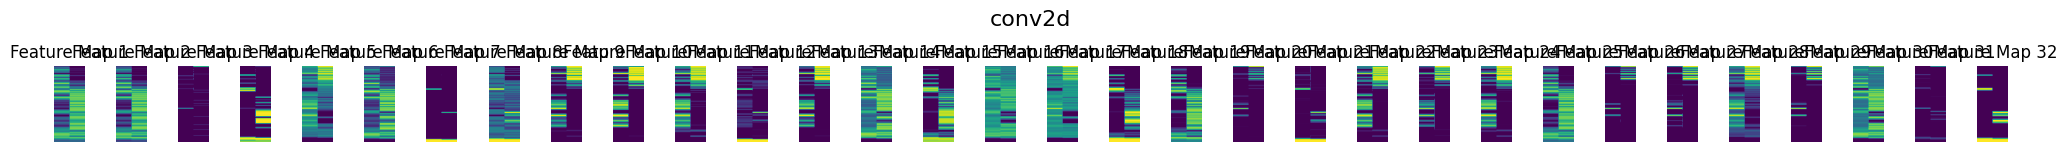

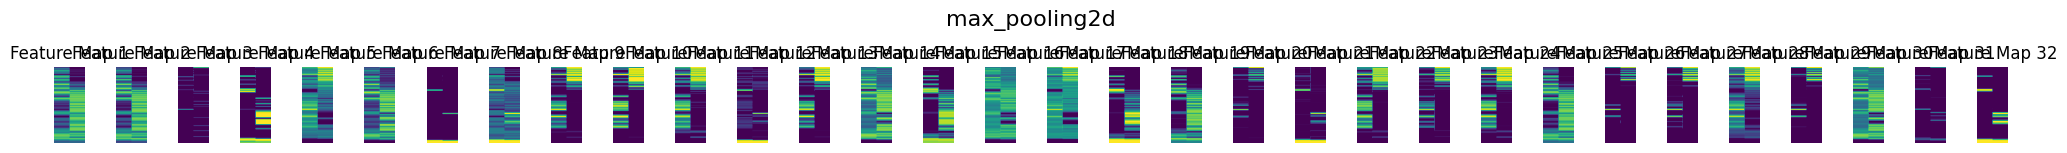

/Users/felipe/Documents/Sober/Testers/final_ml.py:538: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/Users/felipe/Documents/Sober/Testers/final_ml.py:542: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


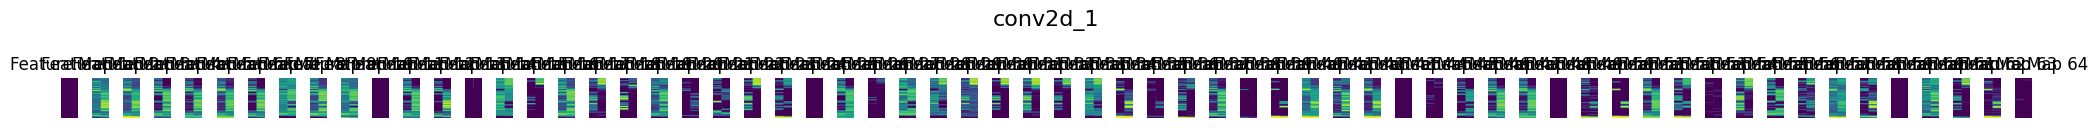

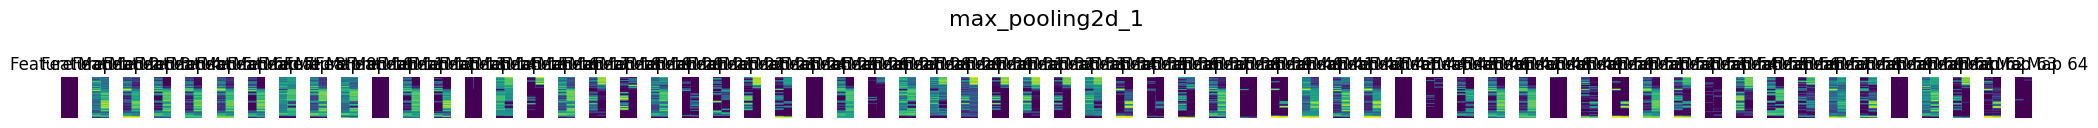

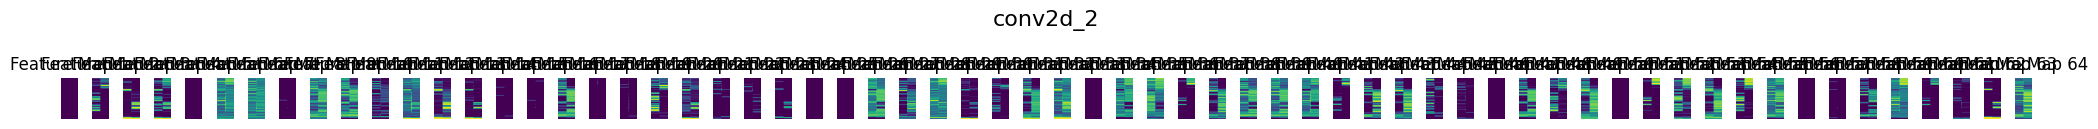

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
# run CNN
cnn_features_labeledCSV_folder = '/Users/felipe/Documents/Sober/Testers/cnn_features_labeledCSV_folder' #folder where you want the csv file with the syllables, cnn features, and labels stored
vis_featMaps_path = '/Users/felipe/Documents/Sober/Testers/saveSpec_folder/wh13wh95_010224_0638.1920_syllable6.png' #path of the image you want to visualize the feature maps for, leave empty if you don't want to
vis_filters = 8 #num of filters you want to visualize of the first layer

cnn_features_labeledCSV_path = processor.CNN(images_folder, labeled_filteredCSV_path, cnn_features_labeledCSV_folder, vis_featMaps_path, vis_filters)
#returns path of CSV with syllables, cnn features, and their labels
